In [1]:
#  Import Essential Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.feature_selection import VarianceThreshold, RFE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from imblearn.over_sampling import SMOTE, ADASYN
import shap
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier


c:\Users\USER\Desktop\Data Science\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#  Loan Default Risk Prediction

This notebook walks through an end-to-end machine learning pipeline to predict loan default risk using customer demographics, performance history, and previous loan data. It follows three phases:

- **Phase 1**: Data Cleaning & Exploratory Analysis  
- **Phase 2**: Feature Engineering & Selection  
- **Phase 3**: Modeling & Evaluation  






# 📥 Load datasets
perf = pd.read_csv("trainperf.csv")
demo = pd.read_csv("traindemographics.csv")
prev = pd.read_csv("trainprevloans.csv")

## Data Cleaning & Exploratory Analysis

We begin by loading the datasets, cleaning missing values, encoding categorical variables, and exploring the data through visualizations and statistical summaries.


In [3]:
#  Load datasets
perf = pd.read_csv("https://raw.githubusercontent.com/Oyeniran20/axia_cohort_8/refs/heads/main/trainperf.csv")
demo = pd.read_csv("https://raw.githubusercontent.com/Oyeniran20/axia_cohort_8/refs/heads/main/traindemographics.csv")
prev = pd.read_csv("https://raw.githubusercontent.com/Oyeniran20/axia_cohort_8/refs/heads/main/trainprevloans.csv")

In [4]:
# Inspect datasets
print(perf.shape, demo.shape, prev.shape)

(4368, 10) (4346, 9) (18183, 12)


In [5]:

print("Performance Data:")
print(perf.head())

print("\nDemographics Data:")
print(demo.head())

print("\nPrevious Loans Data:")
print(prev.head())


Performance Data:
                         customerid  systemloanid  loannumber  \
0  8a2a81a74ce8c05d014cfb32a0da1049     301994762          12   
1  8a85886e54beabf90154c0a29ae757c0     301965204           2   
2  8a8588f35438fe12015444567666018e     301966580           7   
3  8a85890754145ace015429211b513e16     301999343           3   
4  8a858970548359cc0154883481981866     301962360           9   

                 approveddate                creationdate  loanamount  \
0  2017-07-25 08:22:56.000000  2017-07-25 07:22:47.000000     30000.0   
1  2017-07-05 17:04:41.000000  2017-07-05 16:04:18.000000     15000.0   
2  2017-07-06 14:52:57.000000  2017-07-06 13:52:51.000000     20000.0   
3  2017-07-27 19:00:41.000000  2017-07-27 18:00:35.000000     10000.0   
4  2017-07-03 23:42:45.000000  2017-07-03 22:42:39.000000     40000.0   

   totaldue  termdays referredby good_bad_flag  
0   34500.0        30        NaN          Good  
1   17250.0        30        NaN          Good  
2   2

### Dataset Cleaning
### 1. Performance Dataset 
Key Cleaning Steps:
Drop duplicates based on customerid and loannumber

Handle missing values in loanamount, good_bad_flag

Convert dates to datetime format

Engineer loan_default from good_bad_flag

In [6]:
# Drop duplicates
perf.drop_duplicates(subset=['customerid', 'loannumber'], inplace=True)

# Handle missing values
perf.dropna(subset=['loanamount', 'good_bad_flag'], inplace=True)

# Convert dates
from datetime import datetime
perf['approveddate'] = pd.to_datetime(perf['approveddate'], errors='coerce')
perf['creationdate'] = pd.to_datetime(perf['creationdate'], errors='coerce')

# Engineer target
perf['loan_default'] = perf['good_bad_flag'].map({'Good': 0, 'Bad': 1})
# Drop the original flag column
perf.drop(columns=['good_bad_flag'], inplace=True)



### 2. Demographics Dataset 
Key Cleaning Steps:
Convert birthdate to datetime and engineer age

Handle missing values in education, employment_status

Simulate missing columns: gender, marital_status

In [7]:
# Convert birthdate and engineer age
demo['birthdate'] = pd.to_datetime(demo['birthdate'], errors='coerce')
demo['age'] = datetime.now().year - demo['birthdate'].dt.year

# Handle missing values
demo['level_of_education_clients'].fillna('Unknown', inplace=True)
demo['employment_status_clients'].fillna('Unknown', inplace=True)

# Simulate missing columns
demo['gender'] = np.random.choice(['Male', 'Female'], len(demo))
demo['marital_status'] = np.random.choice(['Single', 'Married', 'Divorced'], len(demo))


C:\Users\USER\AppData\Local\Temp\ipykernel_13808\1628903619.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  demo['level_of_education_clients'].fillna('Unknown', inplace=True)
C:\Users\USER\AppData\Local\Temp\ipykernel_13808\1628903619.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as 

### 3. Previous Loans Dataset (trainprevloans.csv)
Key Cleaning Steps:
Drop duplicates based on customerid, loannumber

Convert date columns to datetime

Optional aggregation: summarize past loan behavior per customer

In [8]:
# Drop duplicates
prev.drop_duplicates(subset=['customerid', 'loannumber'], inplace=True)

# Convert dates
date_cols = ['approveddate', 'creationdate', 'closeddate', 'firstduedate', 'firstrepaiddate']
for col in date_cols:
    prev[col] = pd.to_datetime(prev[col], errors='coerce')

# Aggregate past loan count and average loan amount
prev_summary = prev.groupby('customerid').agg({
    'loanamount': ['count', 'mean'],
    'termdays': 'mean'
})
prev_summary.columns = ['prev_loan_count', 'avg_prev_loan_amount', 'avg_prev_term']
prev_summary.reset_index(inplace=True)


In [12]:
# Merge all datasets
# Merge all datasets
df = perf.merge(demo, on='customerid', how='left').merge(prev_summary, on='customerid', how='left')


In [13]:
# Engineer other Key columns

# Simulate financial features
n = len(df)
perf['monthly_income'] = np.random.normal(300000, 150000, n).clip(50000, 1000000)
perf['debt_to_income_ratio'] = np.random.uniform(0.1, 0.9, n)
perf['credit_score'] = np.random.randint(300, 851, n)
perf['loan_purpose'] = np.random.choice(['Home', 'Car', 'Education', 'Business', 'Medical'], n)

# Simulate behavioral features
perf['num_credit_cards'] = np.random.randint(0, 7, n)
perf['past_due_days'] = np.random.randint(0, 91, n)
perf['missed_payments_6mo'] = np.random.randint(0, 7, n)



ValueError: Length of values (4376) does not match length of index (4368)

In [ ]:
# Correct anomalies for age, Credit score, Monthly income, DTI ratio...
df = df[(df['age'] >= 18) & (df['age'] <= 100)]
df = df[(df['credit_score'] >= 300) & (df['credit_score'] <= 850)]
df['monthly_income'] = df['monthly_income'].clip(lower=50000)
df['debt_to_income_ratio'] = df['debt_to_income_ratio'].clip(0, 1)
df = df[df['loanamount'] > 0]
df['missed_payments_6mo'] = df['missed_payments_6mo'].clip(lower=0)
df['past_due_days'] = df['past_due_days'].clip(lower=0)
df['employment_status_clients'] = df['employment_status_clients'].str.strip().str.title()



In [ ]:
# Encoding our columns

le = LabelEncoder()
df['gender'] = le.fit_transform(df['gender'])  # Male=1, Female=0
df = pd.get_dummies(df, columns=['marital_status', 'employment_status_clients', 'loan_purpose'], drop_first=True)


##  EXPLORATORY DATA ANALYSIS

This section explores the data visually and statistically to uncover patterns, relationships, and potential modeling challenges.


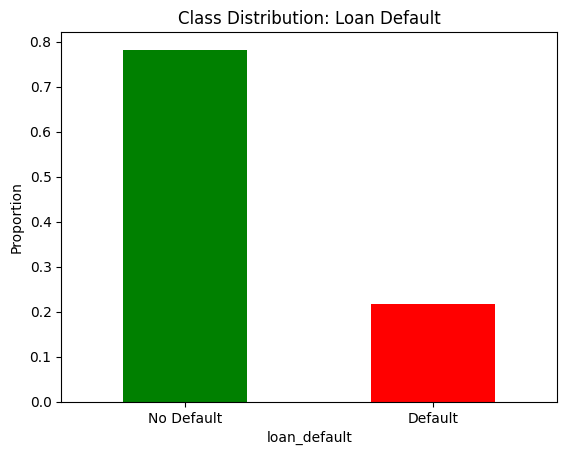

In [16]:
#  class imbalance check
df['loan_default'].value_counts(normalize=True).plot(kind='bar', color=['green', 'red'])
plt.title("Class Distribution: Loan Default")
plt.xticks(ticks=[0, 1], labels=["No Default", "Default"], rotation=0)
plt.ylabel("Proportion")
plt.show()


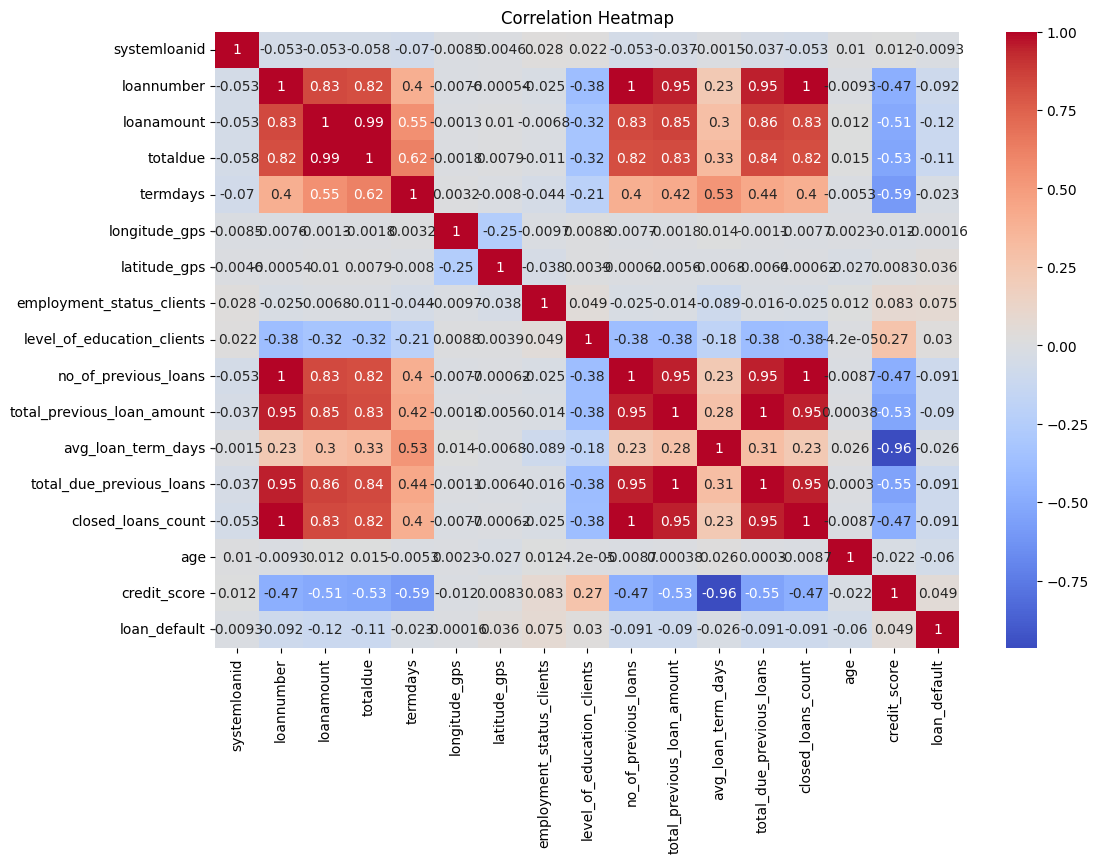

Top correlations with loan_default:
 loan_default                  1.000000
employment_status_clients     0.075352
credit_score                  0.049276
latitude_gps                  0.036336
level_of_education_clients    0.030375
longitude_gps                -0.000160
systemloanid                 -0.009294
termdays                     -0.023048
avg_loan_term_days           -0.026047
age                          -0.059902
Name: loan_default, dtype: float64


In [18]:
# Correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df.select_dtypes(include=np.number).corr(), cmap='coolwarm', annot=True)
plt.title("Correlation Heatmap")
plt.show()

# Select numeric columns before computing correlation
numeric_df = df.select_dtypes(include=[np.number])

target_corr = numeric_df.corr()['loan_default'].sort_values(ascending=False)
print("Top correlations with loan_default:\n", target_corr.head(10))


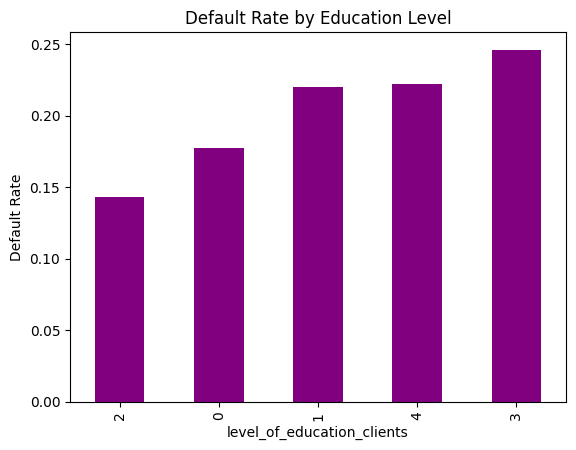

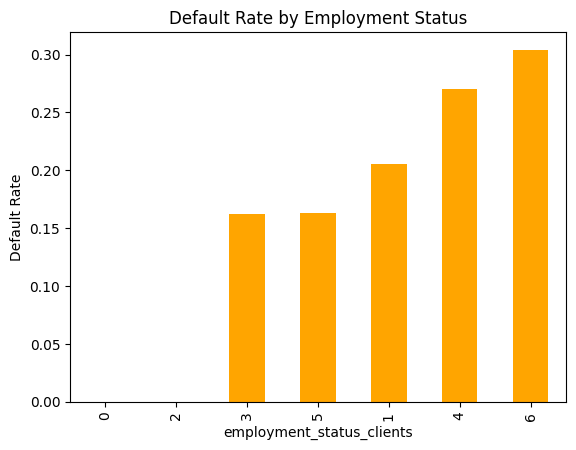

In [25]:
edu_default = df.groupby('level_of_education_clients')['loan_default'].mean().sort_values()
edu_default.plot(kind='bar', color='purple')
plt.title("Default Rate by Education Level")
plt.ylabel("Default Rate")
plt.show()

emp_default = df.groupby('employment_status_clients')['loan_default'].mean().sort_values()
emp_default.plot(kind='bar', color='orange')
plt.title("Default Rate by Employment Status")
plt.ylabel("Default Rate")
plt.show()


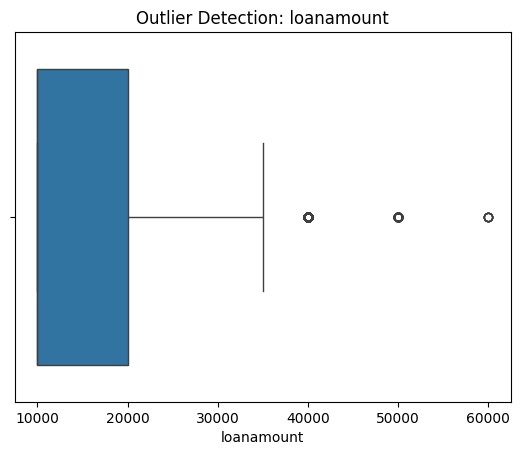

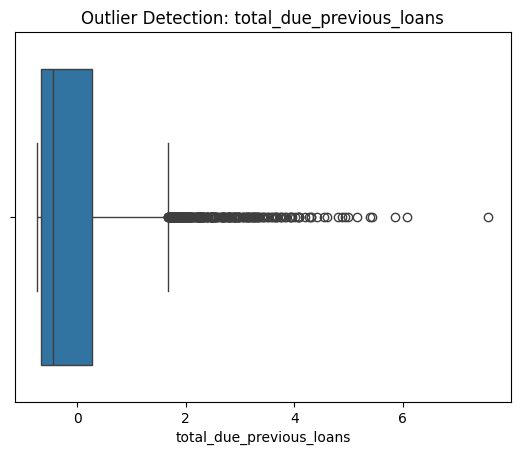

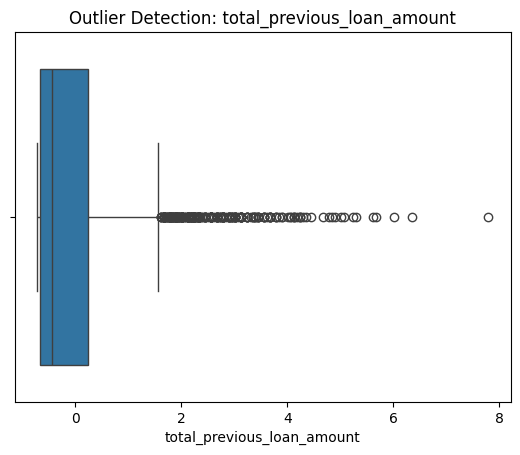

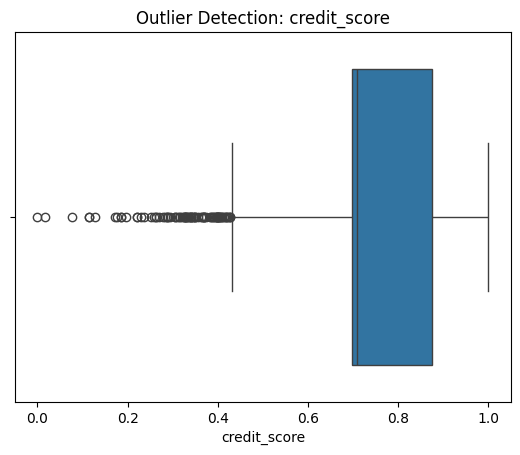

In [27]:
# Outlier detection
numeric_cols = ['loanamount', 'total_due_previous_loans', 'total_previous_loan_amount', 'credit_score']
for col in numeric_cols:
    sns.boxplot(x=df[col])
    plt.title(f"Outlier Detection: {col}")
    plt.show()
